<a href="https://colab.research.google.com/github/Danny-Jang/doctor-ai-project/blob/master/skin_cancer_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
print(keras.__version__)

2.4.3


In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras import optimizers,regularizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization 
from keras.applications import ResNet50, Xception

In [ ]:
base_model= ResNet50(include_top=False, weights= 'imagenet', input_shape=(224,224,3))

94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
model= Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
regularizers.l2(l2=0.01)
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
regularizers.l2(l2=0.01)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          1179712   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 64)          256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 64)          0

In [ ]:
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                    #  validation_split = 0.2,
                                     rotation_range=10,  
                                     zoom_range = 1.3, 
                                     width_shift_range=0.3,  
                                     height_shift_range=0.3,
                                     horizontal_flip=True
                                    #  vertical_flip=True
                                    ) 

test_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
# from keras import optimizers
# from keras_preprocessing.image import ImageDataGenerator
# train_generator = ImageDataGenerator(
#                                     featurewise_center=False,
#                                     samplewise_center=True,
#                                     featurewise_std_normalization=False,
#                                     samplewise_std_normalization=True,
#                                     zca_whitening=False,
#                                     zca_epsilon=0,
#                                     rotation_range= 10,
#                                     width_shift_range=0.1,
#                                     height_shift_range=0.1,
#                                     # brightness_range=(0.1,0.5),
#                                     shear_range= 10,
#                                     zoom_range= 1.3,
#                                     channel_shift_range=0.0,
#                                     # fill_mode="nearest",
#                                     cval=0.0,
#                                     horizontal_flip=True,
#                                     vertical_flip=True,
#                                     rescale=1/255,
#                                     preprocessing_function=None,
#                                     validation_split=0.0,
#                                     )

# test_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_generator.flow_from_directory('/content/drive/My Drive/skin_cancer/increased_data2/train',
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical'
                                                )


test_set = test_generator.flow_from_directory('/content/drive/My Drive/skin_cancer/increased_data2/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 5000 images belonging to 2 classes.
Found 1265 images belonging to 2 classes.


In [ ]:
training_set.samples

5000

In [ ]:
test_set.samples

1265

In [ ]:
training_set.batch_size

64

In [ ]:
model.compile(optimizer= optimizers.Adam(learning_rate = 0.00005),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
earlystopping = EarlyStopping(monitor = 'val_loss', patience=20)
modelcheckpoint = ModelCheckpoint(filepath = "/content/drive/My Drive/skin_cancer/skin_cancer_best_model3.h5", save_best_only = True, monitor = 'val_accuracy', verbose = 1)

def scheduler(epoch, lr):
    epoch += 1
    lr = 0.1
    lr = lr / (epoch * 10) 
    return lr 

lrscheduler = LearningRateScheduler(scheduler,verbose = 1)

ReduceLROnPlateau: 학습 되지 않을때 학습률을 줄임





In [ ]:
history =   model.fit(training_set,
                    steps_per_epoch=training_set.samples//training_set.batch_size,
                    validation_data=test_set,
                    verbose=1,
                    validation_steps=test_set.samples//test_set.batch_size,
                    epochs = 100,
                    callbacks = [modelcheckpoint, reduce_lr, earlystopping]
                        )

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.9183 - accuracy: 0.5993 
Epoch 00001: val_accuracy improved from -inf to 0.54605, saving model to /content/drive/My Drive/skin_cancer/skin_cancer_best_model3.h5
78/78 [==============================] - 3558s 46s/step - loss: 0.9183 - accuracy: 0.5993 - val_loss: 0.6987 - val_accuracy: 0.5461
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.7192
Epoch 00002: val_accuracy did not improve from 0.54605
78/78 [==============================] - 103s 1s/step - loss: 0.6747 - accuracy: 0.7192 - val_loss: 0.6901 - val_accuracy: 0.5452
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.7626
Epoch 00003: val_accuracy did not improve from 0.54605
78/78 [==============================] - 102s 1s/step - loss: 0.5762 - accuracy: 0.7626 - val_loss: 0.7229 - val_accuracy: 0.4416
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.5260 

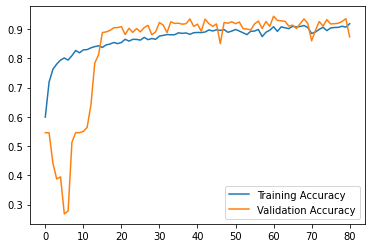

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


import matplotlib.pyplot as plt

plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

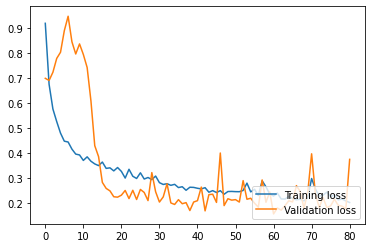

In [ ]:
acc = history.history['loss']
val_acc = history.history['val_loss']


import matplotlib.pyplot as plt

plt.plot(range(len(acc)), acc, label='Training loss')
plt.plot(range(len(val_acc)), val_acc, label='Validation loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/skin_cancer/skin_cancer_best_model3.h5')

In [ ]:
scores = model.evaluate(test_set, steps = 20)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

20/20 [==============================] - 830s 41s/step - loss: 0.1673 - accuracy: 0.9383
accuracy: 93.83%


In [ ]:
import numpy as np
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
output = model.predict_generator(
            test_set, 
            steps = 20)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)

[[0.805 0.195]
 [0.973 0.027]
 [0.985 0.015]
 [0.996 0.004]
 [0.975 0.025]
 [0.991 0.009]
 [0.974 0.026]
 [0.865 0.135]
 [0.987 0.013]
 [0.995 0.005]
 [0.999 0.001]
 [0.957 0.043]
 [1.000 0.000]
 [0.999 0.001]
 [1.000 0.000]
 [0.266 0.734]
 [0.924 0.076]
 [0.996 0.004]
 [0.999 0.001]
 [0.861 0.139]
 [0.973 0.027]
 [0.759 0.241]
 [0.962 0.038]
 [0.999 0.001]
 [0.649 0.351]
 [0.972 0.028]
 [0.994 0.006]
 [0.979 0.021]
 [0.997 0.003]
 [0.963 0.037]
 [0.851 0.149]
 [0.978 0.022]
 [0.996 0.004]
 [0.034 0.966]
 [0.752 0.248]
 [0.986 0.014]
 [0.992 0.008]
 [0.017 0.983]
 [0.917 0.083]
 [0.996 0.004]
 [0.999 0.001]
 [0.929 0.071]
 [0.990 0.010]
 [0.998 0.002]
 [0.966 0.034]
 [0.220 0.780]
 [0.991 0.009]
 [0.996 0.004]
 [0.962 0.038]
 [0.992 0.008]
 [1.000 0.000]
 [0.446 0.554]
 [0.999 0.001]
 [0.999 0.001]
 [0.956 0.044]
 [0.924 0.076]
 [1.000 0.000]
 [1.000 0.000]
 [0.979 0.021]
 [0.976 0.024]
 [0.999 0.001]
 [1.000 0.000]
 [0.973 0.027]
 [0.996 0.004]
 [0.566 0.434]
 [0.999 0.001]
 [0.984 0.

In [ ]:
len(output)

1265

In [ ]:
test_set.reset()
predictions = model.predict(test_set, steps=test_set.samples/test_set.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

print(y_pred)

20/19 [==============================] - 4s 221ms/step
[0 0 0 ... 1 1 0]


In [ ]:
len(y_pred)

1265

In [ ]:
import numpy as np
y_test=np.array([])
for i in range(663):
    y_test=np.append(y_test,0)
for i in range(602):
    y_test=np.append(y_test,1)

In [ ]:
y_test

array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000,

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, con
cm= confusion_matrix(y_test,y_pred)

In [ ]:
cm

array([[632,  31],
       [ 47, 555]])

In [ ]:
ConfusionMatrixDisplay(cm, display_labels=('benign', 'malignant')).plot(values_format = 'd' ,cmap = 'GnBu')


NameError: ignored

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred)

In [ ]:
len(training_set[0])

In [ ]:
len(training_set[0][0][0])

In [ ]:
training_set[0][0][0].shape

In [ ]:
training_set[0][0].shape

In [ ]:
len(training_set[0][0])

In [ ]:
len(training_set[0][1])

In [ ]:
from keras.preprocessing import image

img_data = image.load_img('/content/drive/My Drive/skin_cancer/increased_data2/test/benign/50.jpg', target_size = (224,224,3))

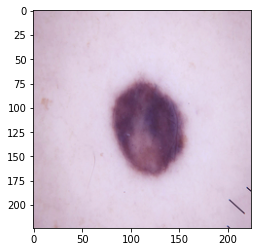

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_data)
plt.show()

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/drive/My Drive/skin_cancer/increased_data2/test/malignant/50.jpg')
model.predict(image)
image.resize(224,224,3)


In [ ]:
image.shape

(224, 224, 3)